# Cpu optimization

In this section, we assess different methods to optimize N-body simulations with Python on CPU.
This task is approached in two ways: 
1.  Optimizing the computation of accelerations, for a given single simulation;

2. Optimizing independent simulations run in parallel.

For the first approach we use the built-in `multiprocessing` and the external `numba` library, while for the second only the former is considered. 

We find a significant speed-up of the code in both cases (**aggiungi quanto**), even though optimization fails when we try to mix the two methods, i.e. when running multiple independent simulations, while computing the accelerations in an optimized fashion.


**rimuovi il seguente poi**
* what is Multiprocessing? (how cpu works, ALU)
* what is the GIL? (what's njit and parallel?)

* how did you implement the codes?
* final considerations --> who wins?

## Using all cores in a single simulation
Modern CPUs come with multiple cores that may run multiple computations, if well programmed. A naive approach to estimating the accelerations in a N-body simulation consists in writing two nested for loops, that for each particle compute the force with respect to all others. ** add code? ** We refer to this as a *direct* estimation of the forces. Since Python is an interpreted language, direct estimation performs very badly, and indeed we see that only one core is used when using this method (this is done by visually insepcting the cores used, running `htop` in a bash terminal). ** aggiungere immagine htop??** 
A first optimization is implemented by exploiting Numpy's broadcasting. We refer to this as a *vectorized* estimation. By doing so, we see that Numpy automatically uses 4 cores, instead of just one (Numpy is written in compiled C). This results in a much faster estimation,* as discussed in the assignments of this class ???* .  

In a 8-core CPU this is still not the best result achievable, since there are still 4 unused cores. Here we explore the idead that, since Numpy uses 4 cores, we should be able to run our estimations at least two times faster, when using a 8-core CPU. The gain obtained will be greater as the number of cores available gets bigger.

This is implemented by using both the `multiprocessing` and `numba` libraries.


## Multiprocessing

Another possibility is to use all the cores available to run multiple independent simulations, allocating a subset of the CPU each. This goes under the name of **multiprocessing**, and each independent simulation is called a **process**.  It is important to remark that each process has an independent memory, thus it does not communicate with the other processes, even though they run on the same CPU at the same time. This feature discriminate it from **multithreading**, which shares a common memory between different threads running in parallel.

Multiprocessing is also used to parallelize computations of the acceleration in a single run, by assigning a particles subset to each process.

Each process is taken care of by a **worker**. The set of all workers is called **Pool**. It is good practice to create a Pool just once, but in our implementation it is sometimes opened and closed at each iteration of the evolution, as we will discuss later. In any case, this does not cause a too large overhead. 

* aggiungi immagine multiprocessing ? * 

## Numba's JIT compilation and parallelization

As already mentioned, Python is an interpreted language meaning that a program directly executes instructions, without requiring them previously to have been compiled into a machine language program [[1]](https://en.wikipedia.org/wiki/Interpreter_(computing)). This causes native Python to be much slower than C++, for example. 

Fortunately, it is possible to speed up the code using `numba`, which compiles it to machine code “just-in-time” for execution, making it run at native machine code speed, when possible [[2]](https://numba.readthedocs.io/en/stable/user/5minguide.html). Numba works well with Numpy arrays and it is easy to implement in a standard Python script, since it requires to add just a decorator on our functions.

Numba offers the possibilty to run the code in a multi-threaded fashion, by setting `parallel=True` inside the decorator. Unfortunately, not all codes can be parallelized in this way. In fact, we have been able to use this feature only on the direct estimation, and not on the vectorized one.

We use numba to speed up the estimation of accelerations for a single simulation. We refer to this as *NJIT* estimation, which stands for "no python - just in time".

## Code and results

All results shown in the plots are obtained on separate .py files.  
Let's start by considering parallel accelerations computations on a single evolution. 

### Numba

Here we show the direct and the vectorized functions used, with their numba's counterparts. Notice that numba requires just to add a decorator `@njit` at the beginning of the function, and to use `prange` instead of `range`.

In addition, numpy may need some chenges in order for numba to understand exactly how some objects look like when compiled. This fact is a clear example of the work of Python's interpreter that happens "under the hood". For example 

```python
acc  = np.zeros([N,3]) # This does not work with numba
acc  = np.zeros_like(pos) # Use this instead
```
Or when using reshape, it is necessary to make a copy of the array, in order to make it C-contiguous in the memory.

```python
dx = pos[:, 0].reshape(N_particles, 1) - pos[:, 0] # This does not work with numba
dx = pos[:, 0].copy().reshape(N_particles, 1) - pos[:, 0]  # Use this instead
   
```


The biggest problems arise when trying to compute a matrix multiplication using `parallel=True`. Indeed, `np.matmul` is not implemented and even trying working around this, we are not able to use our vectorized function in a parallel way. 

In [2]:
from fireworks.ic import ic_random_uniform as ic_random_uniform
import numpy as np
from numba import prange, njit

def acceleration_direct_slow(pos,mass,N,softening):
    jerk = None
    pot = None

    # acc[i,:] ax,ay,az of particle i 
    acc  = np.zeros([N,3])

    for i in range(N-1):
        for j in range(i+1,N):
            # Compute relative acceleration given
            # position of particle i and j
            mass_1 = mass[i]
            mass_2 = mass[j]

            # Compute acceleration of particle i due to particle j
            position_1=pos[i,:]
            position_2=pos[j,:]
            
            # Cartesian component of the i,j particles distance
            dx = position_1[0] - position_2[0]
            dy = position_1[1] - position_2[1]
            dz = position_1[2] - position_2[2]
            

            # Distance module
            r = np.sqrt(dx**2 + dy**2 + dz**2)

            # Cartesian component of the i,j force
            acceleration = np.zeros(3)
            acceleration[0] = -mass_2 * (5*softening**2 + 2*r**2) * dx / (2*(r**2 + softening**2)**(5/2))
            acceleration[1] = -mass_2 * (5*softening**2 + 2*r**2) * dy / (2*(r**2 + softening**2)**(5/2))
            acceleration[2] = -mass_2 * (5*softening**2 + 2*r**2) * dz / (2*(r**2 + softening**2)**(5/2))

            # Update array with accelerations
            acc[i,:] += acceleration
            acc[j,:] -= mass_1 * acceleration / mass_2 # because acc_2nbody already multiply by m[j]
        
    return (acc,jerk,pot)


@njit
def acceleration_direct_fast(pos,mass,N,softening):
    jerk = None
    pot = None

    # acc[i,:] ax,ay,az of particle i 
    #acc  = np.zeros([N,3])
    acc = np.zeros_like(pos)

    for i in range(N-1):
        for j in range(i+1,N):
            # Compute relative acceleration given
            # position of particle i and j
            mass_1 = mass[i]
            mass_2 = mass[j]

            # Compute acceleration of particle i due to particle j
            position_1=pos[i,:]
            position_2=pos[j,:]
            
            # Cartesian component of the i,j particles distance
            dx = position_1[0] - position_2[0]
            dy = position_1[1] - position_2[1]
            dz = position_1[2] - position_2[2]
            

            # Distance module
            r = np.sqrt(dx**2 + dy**2 + dz**2)

            # Cartesian component of the i,j force
            acceleration = np.zeros(3)
            acceleration[0] = -mass_2 * (5*softening**2 + 2*r**2) * dx / (2*(r**2 + softening**2)**(5/2))
            acceleration[1] = -mass_2 * (5*softening**2 + 2*r**2) * dy / (2*(r**2 + softening**2)**(5/2))
            acceleration[2] = -mass_2 * (5*softening**2 + 2*r**2) * dz / (2*(r**2 + softening**2)**(5/2))

            # Update array with accelerations
            acc[i,:] += acceleration
            acc[j,:] -= mass_1 * acceleration / mass_2 # because acc_2nbody already multiply by m[j]
        
    return (acc,jerk,pot)

def slow_acceleration_direct_vectorized(pos,N_particles,mass,softening):
    dx = pos[:, 0].reshape(N_particles, 1) - pos[:, 0] #broadcasting of (N,) on (N,1) array, obtain distance along x in an (N,N) matrix
    dy = pos[:, 1].reshape(N_particles, 1) - pos[:, 1] 
    dz = pos[:, 2].reshape(N_particles, 1) - pos[:, 2] 
    
    r = np.sqrt(dx**2 + dy**2 + dz**2)
    r[r==0]=1
    
    dpos = np.concatenate((dx, dy, dz)).reshape((3,N_particles,N_particles)) 
    acc = - (dpos* (5*softening**2 + 2*r**2)/(2*(r**2 + softening**2)**(5/2)) @ mass).T
    
    jerk= None 
    pot = None

    return acc, jerk, pot


@njit
def fast_acceleration_direct_vectorized(pos,N_particles,mass,softening):
   
    dx = pos[:, 0].copy().reshape(N_particles, 1) - pos[:, 0] #broadcasting of (N,) on (N,1) array, obtain distance along x in an (N,N) matrix
    dy = pos[:, 1].copy().reshape(N_particles, 1) - pos[:, 1] 
    dz = pos[:, 2].copy().reshape(N_particles, 1) - pos[:, 2] 
      
    r = np.sqrt(dx**2 + dy**2 + dz**2)
    #r[r==0]=1 not supported on numba
    r += np.eye(r.shape[0])
    
    dpos = np.concatenate((dx, dy, dz)).copy().reshape((3,N_particles,N_particles)) 
    acc = - np.sum(dpos* (5*softening**2 + 2*r**2)/(2*(r**2 + softening**2)**(5/2)) * mass,axis=2).T
   
    jerk= None
    pot = None

    return acc, jerk, pot



@njit(parallel=True)
def parallel_acceleration_direct_fast(pos,mass,N,softening):
    jerk = None
    pot = None

    # acc[i,:] ax,ay,az of particle i 
    #acc  = np.zeros([N,3])
    acc = np.zeros_like(pos)

    for i in prange(N-1):
        for j in range(i+1,N):
            # Compute relative acceleration given
            # position of particle i and j
            mass_1 = mass[i]
            mass_2 = mass[j]

            # Compute acceleration of particle i due to particle j
            position_1=pos[i,:]
            position_2=pos[j,:]
            
            # Cartesian component of the i,j particles distance
            dx = position_1[0] - position_2[0]
            dy = position_1[1] - position_2[1]
            dz = position_1[2] - position_2[2]
            

            # Distance module
            r = np.sqrt(dx**2 + dy**2 + dz**2)

            # Cartesian component of the i,j force
            acceleration = np.zeros(3)
            acceleration[0] = -mass_2 * (5*softening**2 + 2*r**2) * dx / (2*(r**2 + softening**2)**(5/2))
            acceleration[1] = -mass_2 * (5*softening**2 + 2*r**2) * dy / (2*(r**2 + softening**2)**(5/2))
            acceleration[2] = -mass_2 * (5*softening**2 + 2*r**2) * dz / (2*(r**2 + softening**2)**(5/2))

            # Update array with accelerations
            acc[i,:] += acceleration
            acc[j,:] -= mass_1 * acceleration / mass_2 # because acc_2nbody already multiply by m[j]
        
    return (acc,jerk,pot)




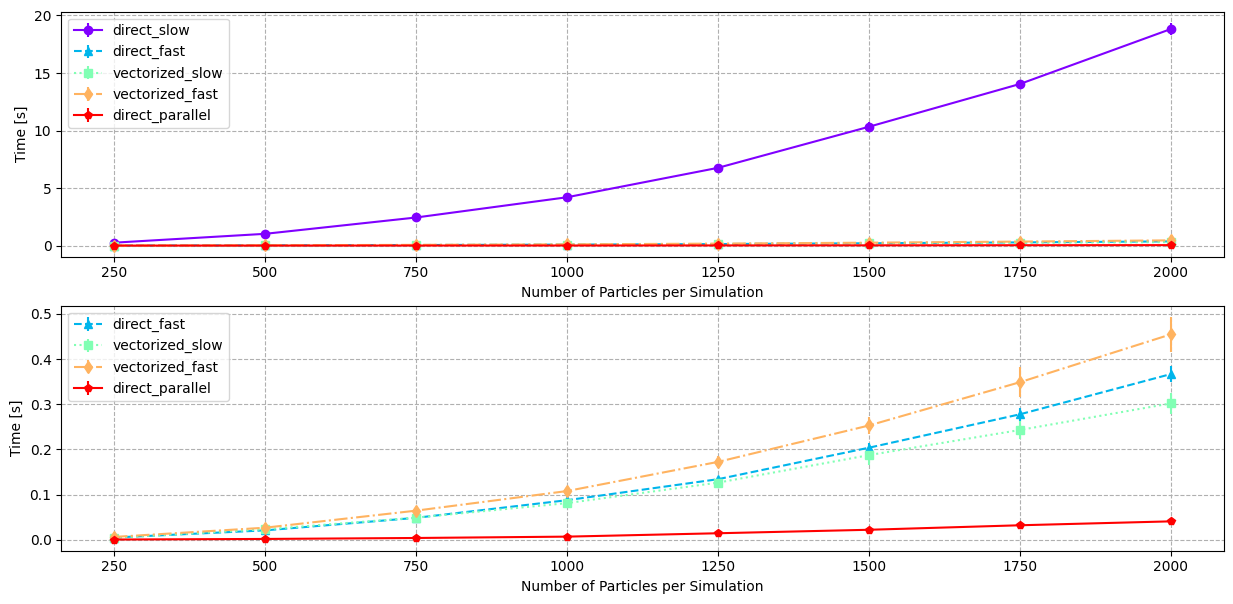

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm
import os 


df = pd.read_csv('numba/numba_timings.csv')
group = df.groupby("n_particles").agg(["mean", "std"])

fig, axs = plt.subplots(2,1,figsize=(15, 7))
colors = [cm.rainbow(i) for i in np.linspace(0, 1, 5)]


i=0
n_particles = np.arange(250,2250,250)
axs[0].errorbar(n_particles, group["direct_slow"].values[:, 0], yerr=group["direct_slow"].values[:, 1], marker="o", label="direct_slow", c=colors[i])
axs[0].errorbar(n_particles, group["direct_fast"].values[:, 0], yerr=group["direct_fast"].values[:, 1], marker="^", linestyle="--", label="direct_fast", c=colors[i+1])
axs[0].errorbar(n_particles, group["vectorized_slow"].values[:, 0], yerr=group["vectorized_slow"].values[:, 1], marker="s", linestyle=":", label="vectorized_slow", c=colors[i+2])
axs[0].errorbar(n_particles, group["vectorized_fast"].values[:, 0], yerr=group["vectorized_fast"].values[:, 1], marker="d", linestyle="-.", label="vectorized_fast", c=colors[i+3])
axs[0].errorbar(n_particles, group["direct_parallel"].values[:, 0], yerr=group["direct_parallel"].values[:, 1], marker="p", linestyle="-", label="direct_parallel", c=colors[i+4])
    

  
# Set labels and title
axs[0].set_xlabel('Number of Particles per Simulation')
axs[0].set_ylabel('Time [s]')
axs[0].grid(linestyle='--')
axs[0].legend(handles=axs[0].get_legend_handles_labels()[0][:5], labels=axs[0].get_legend_handles_labels()[1][:5], loc="upper left")

############################################
axs[1].errorbar(n_particles, group["direct_fast"].values[:, 0], yerr=group["direct_fast"].values[:, 1], marker="^", linestyle="--", label="direct_fast", c=colors[i+1])
axs[1].errorbar(n_particles, group["vectorized_slow"].values[:, 0], yerr=group["vectorized_slow"].values[:, 1], marker="s", linestyle=":", label="vectorized_slow", c=colors[i+2])
axs[1].errorbar(n_particles, group["vectorized_fast"].values[:, 0], yerr=group["vectorized_fast"].values[:, 1], marker="d", linestyle="-.", label="vectorized_fast", c=colors[i+3])
axs[1].errorbar(n_particles, group["direct_parallel"].values[:, 0], yerr=group["direct_parallel"].values[:, 1], marker="p", linestyle="-", label="direct_parallel", c=colors[i+4])
    

  
# Set labels and title
axs[1].set_xlabel('Number of Particles per Simulation')
axs[1].set_ylabel('Time [s]')
axs[1].grid(linestyle='--')
axs[1].legend(handles=axs[1].get_legend_handles_labels()[0][:5], labels=axs[1].get_legend_handles_labels()[1][:5], loc="upper left")


#plt.savefig("numba_timings.png")

We see that direct_slow is by far the slowest. Among the optimized functions, we see from fastest to slowest:

* `direct_parallel`: two nested for loops, using `njit(parallel=True)`. This is by far the fastest, by almost 3 to 5 times with respect to the others. It beats numpy's broadcasting too,showing that bypassing altogether numpy's interpretation, a machine-compiled code that uses all available cores is the fastest implementation possible.

* `vectorized_slow`: vectorized version, without using numba. This is still faster than the numba-optimized version. This suggests that Numpy is already self-optimized and adding other computations to it only makes it slower. Take-home message: let numpy do its best and leave it alone.

* `direct_fast`: two nested for loops, using` njit(parallel=False)`. Numba speeds up greatly the native version, but without parallelization it is still slower than numpy's broadcasting, that uses 4 cores on its own.

* `vectorized_fast`: vectorized version, using `njit(parallel=False)`. As discussed in the second point, this only adds an overhead and actually slows down the already-optimized numpy.

### Multiprocessing - single evolution, parallel computations
Here we use the `multiprocessing` library to tell python how to parallelize the code. As you can see, a Pool is created with a number of workers equal to the number of cores. All workers share the same memory storing the particles informations, by declaring global variables. To not run into a race condition, the function is rewritten in order for the workers to manage only a specified subset of particles. This is done by using the map_async function * controlla e spiega differenza synch/asynch*, that explicitly feeds slices of particles to the function that computes the acceleration. ***Moreover, to synch all processes between different iterations (i.e. different tsteps), the Pool is opened and closed at each tstep. However, this doesn't add much overhead as shown in the following plots. E' VERO??? CONTROLLA. HAI FATTO LA VERSIONE IN CUI CIò NON ACCADE, HAI RACE CONDITIONS??*** 

Finally, we show an extra analysis comparing the performance of the `multiprocessing.pool.Pool` vs `multiprocessing.pool.ThreadPool` methods. Theory states that the latter should be used for IO-bound tasks, whilst the former class for CPU-bound tasks, which is our case [[3]](https://superfastpython.com/threadpool-vs-pool-in-python/). However, first euristical trials suggested that ThreadPool could be faster here. After a more statistically robust analysis, we find that the two methods are equivalent for our application.

In [6]:
#### VECTORIZED ####
"""
Here a single run is evolved. It is the computation of the acceleration that is parallelized.

"""
from fireworks.ic import ic_two_body as ic_two_body
from fireworks.ic import ic_random_uniform as ic_random_uniform

from fireworks.nbodylib import dynamics as dyn
from fireworks.nbodylib import integrators as intg


import matplotlib.pyplot as plt
import numpy as np

import time
import multiprocessing
from multiprocessing import Pool
from multiprocessing.pool import ThreadPool
import os 



def acceleration_direct_vectorized(N_particles, pos, mass):
   
    dx = pos[:, 0].reshape(N_particles, 1) - pos[:, 0] #broadcasting of (N,) on (N,1) array, obtain distance along x in an (N,N) matrix
    dy = pos[:, 1].reshape(N_particles, 1) - pos[:, 1] 
    dz = pos[:, 2].reshape(N_particles, 1) - pos[:, 2] 
      
    r = np.sqrt(dx**2 + dy**2 + dz**2)
    r[r==0]=1
    
    dpos = np.concatenate((dx, dy, dz)).reshape((3,N_particles,N_particles)) 


    acc = - (dpos/r**3 @ mass).T
    jerk= None
    pot = None

    return acc, jerk, pot

def parallel_acc(a,b):

    # global particles doesn't work
    global pos
    global N_particles
    global mass
  
    N_subset = abs(b-a)

    # Select particles from a to b to parallelize computation
    # Need to rewrite the function in order to compute quantities of subset of particles wrt all the others
    dx = pos[a:b, 0,np.newaxis] - pos[:, 0] #broadcasting of (N,) on (N,1) array, obtain distance along x in an (N,N) matrix
    dy = pos[a:b, 1,np.newaxis] - pos[:, 1] 
    dz = pos[a:b, 2,np.newaxis] - pos[:, 2] 
      
    r = np.sqrt(dx**2 + dy**2 + dz**2)
    r[r==0]=1
    # New dpos shape is (3,N_subset,N_particles) since 
    # 3 is the number of dimensions, 
    # N_subset is the number of particles in the subset and
    # N_particles is the number of total particles
    # dpos is the distance vector between each particle in the subset and all the others

    dpos = np.concatenate((dx, dy, dz)).reshape((3,N_subset,N_particles)) 
   
    acc = - (dpos/r**3 @ mass).T
    jerk= None
    pot = None

    return acc, jerk, pot


def parallel_integrator(a,b):
    
    global vel
    global pos 
    global tstep
    # global acc 
    # acceleration is needed only to update vel and pos, so it is not needed as a global variable
 
    acc, _ , _ = parallel_acc(a,b) 

    # Euler integration
    vel[a:b] = vel[a:b] + acc * tstep  # Update vel
    pos[a:b] = pos[a:b] + vel[a:b] * tstep  # Update pos

    # no need to update a global acceleration

    # Return the updated particles, the acceleration, jerk (can be None), and potential (can be None)
    return pos[a:b], vel[a:b]


def parallel_evo(N_particles,total_evo_time):
    global pos
    global vel

    #### MULTIPROCESSING ####
    # define the number of processes
    N_CORES = multiprocessing.cpu_count() # in my case 8 cores
    N_PROCESSES = min(N_CORES, N_particles)
    # create a pool of processes
    pool = Pool(N_PROCESSES) 

    positions = []
    # submit multiple instances of the function full_evo 
    # - starmap_async: allows to run the processes with a (iterable) list of arguments
    # - map_async    : is a similar function, supporting a single argument
    for _ in range(int(total_evo_time/tstep)):
        if N_particles < N_PROCESSES:
            # 1 process per particle
            future_results = pool.starmap_async(parallel_integrator, 
                                        [(i, (i + 1)) for i in range(N_particles)])
        else:
            # divide in equal part the particles into N_PROCESSES
            future_results = pool.starmap_async(parallel_integrator, 
                                    [(i * N_particles // N_PROCESSES, (i + 1) * N_particles // N_PROCESSES) for i in range(N_PROCESSES)])



        # to get the results all processes must have been completed
        # the get() function is therefore _blocking_ (equivalent to join) 
        results = future_results.get()
        
        # update global variables directly
        pos = np.concatenate([results[i][0] for i in range(len(results))])
        vel = np.concatenate([results[i][1] for i in range(len(results))])
        
        positions.append(pos)
    

    # close the pool
    # Warning multiprocessing.pool objects have internal resources that need to be properly managed 
    # (like any other resource) by using the pool as a context manager or by calling close() and terminate() manually. Failure to do this can lead to the process hanging on finalization.
    pool.close()

    return results




def main(n_particles):
    # Mock main function, just to show how to use the parallel_evo function
    # For actual implementation, see the .py file (probably not submitted as attachement btw)
    global pos
    global vel
    global mass
    global N_particles
    global tstep
    
    particles = ic_random_uniform(n_particles, [0,3],[0,3],[0,3])
    pos = particles.pos
    vel = particles.vel
    mass = particles.mass
    N_particles = len(particles)   
    tstep = 0.01

    # Run parallel simulations
    results = parallel_evo(N_particles, total_evo_time=tstep)
    
    return results
    

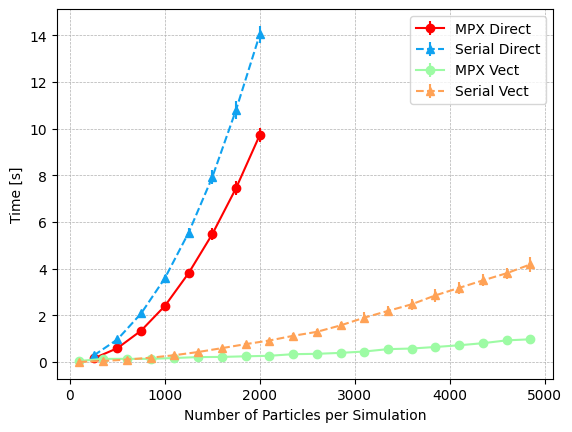

In [7]:
df = pd.read_csv("./multiprocessing/parallel_single_evo/POOL_single_evo_parallel_computation.csv")
std_group = df.groupby("n_particles")[["parallel_time","serial_time"]].agg(["mean","std"])
df3 = pd.read_csv("./multiprocessing/parallel_single_evo/for_loop_single_evo_mpx.csv")
std_group3 = df3.groupby("n_particles")[["parallel_time","serial_time"]].agg(["mean","std"])



fig, ax = plt.subplots()

colors = [cm.rainbow(i) for i in np.linspace(0, 1, 10)]

i = 0 
# each group has n_particles fixed (that is its "name")
n_particles_for = std_group3["parallel_time"]["mean"].keys().get_level_values(0).values
n_particles_vect = std_group["parallel_time"]["mean"].keys().get_level_values(0).values

# std_group è vectorized
# std_group3 è for loop

ax.errorbar(n_particles_for, std_group3["parallel_time"].values[:,0], yerr=std_group3["parallel_time"].values[:,1], marker="o", label="MPX Direct", c=colors[9], linestyle='-')
ax.errorbar(n_particles_for, std_group3["serial_time"].values[:,0], yerr=std_group3["serial_time"].values[:,1], marker="^", label="Serial Direct", c=colors[2], linestyle='--')

ax.errorbar(n_particles_vect, std_group["parallel_time"].values[:,0], yerr=std_group["parallel_time"].values[:,1], marker="o", label="MPX Vect", c=colors[5], linestyle='-')
ax.errorbar(n_particles_vect, std_group["serial_time"].values[:,0], yerr=std_group["serial_time"].values[:,1], marker="^", label="Serial Vect", c=colors[7], linestyle='--')



# Set labels and title
ax.set_xlabel('Number of Particles per Simulation')
ax.set_ylabel('Time [s]')
#ax.set_title(f'Number of Parallel simulations = {name}')
ax.grid(linestyle='--', linewidth=0.5)


ax.legend()

#plt.savefig("comparison_single_evo_parallel_compute.pdf")
# Show the plot
plt.show()


We see that our multiprocessing implementation succeedingly speeds up the code up to $\sim 4$ times. Pay attention to the fact that for less than $\sim 1000$ particles there is no benefit in introducing multiprocessing. The speed-up is due to the fact that multiprocessing uses all the cores available. We already mentioned that our standard vectorized function uses 4 cores, thus we expected multiprocessing to take half time, since it uses 8 cores on our machine. Instead, it accelerates even more, showing that there is a better memeory managment.

The best optimization is reached by parallelizing the vectorized function. Contrary to the numba optimization, numpy benefits from multiprocessing in this case. This may be due to the fact that we do not modify the behaviour of numpy per se, but instead we just control how memory is distributed across cores.

Let's see ThreadPool vs Pool. In the following plot we see that the two methods are completely equal, at least in the range of particles that we assessed. We may see a difference if the task had a bigger I/O bound.

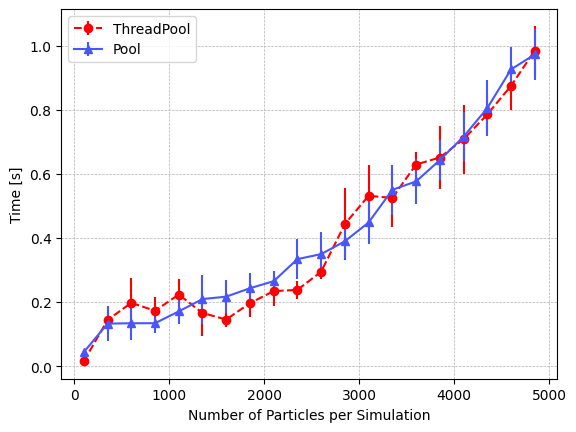

In [ ]:
# Plots considering vectorized only
df2 = pd.read_csv("multiprocessing/parallel_single_evo/THREADPOOL_single_evo_parallel_computation.csv")
std_group2 = df2.groupby("n_particles")[["time_single_parallel","time_single_serial"]].agg(["mean","std"])

fig, ax = plt.subplots()

colors = [cm.rainbow(i) for i in np.linspace(0, 1, 10)]

i = 0 
# each group has n_particles fixed (that is its "name")
n_particles2 = std_group2["time_single_parallel"]["mean"].keys().get_level_values(0).values


ax.errorbar(n_particles2, std_group2["time_single_parallel"].values[:,0], yerr=std_group2["time_single_parallel"].values[:,1], marker="o", label="ThreadPool", c=colors[9], linestyle='--')
ax.errorbar(n_particles, std_group["parallel_time"].values[:,0], yerr=std_group["parallel_time"].values[:,1], marker="^", label="Pool", c=colors[1], linestyle='-')

# Set labels and title
ax.set_xlabel('Number of Particles per Simulation')
ax.set_ylabel('Time [s]')
#ax.set_title(f'Number of Parallel simulations = {name}')
ax.grid(linestyle='--', linewidth=0.5)


ax.legend()

#plt.savefig("Pool_vs_ThreadPool.pdf")
# Show the plot
plt.show()


### Numba vs Multiprocessing. What's the fastest method to compute acceleration?


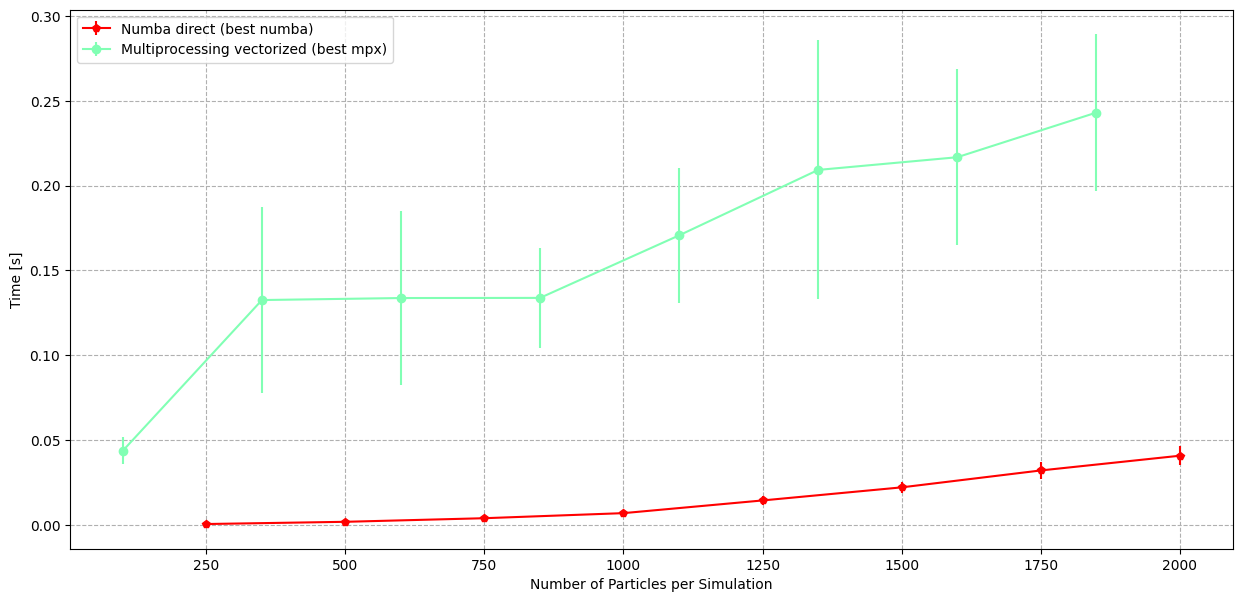

In [9]:
df_numba = pd.read_csv('numba/numba_timings.csv')
group_numba = df_numba.groupby("n_particles").agg(["mean", "std"])
df_pool = pd.read_csv("/ca23/ext_volume/project/multiprocessing/parallel_single_evo/POOL_single_evo_parallel_computation.csv")
group_pool = df_pool.groupby("n_particles")[["parallel_time","serial_time"]].agg(["mean","std"])

fig, axs = plt.subplots(figsize=(15, 7))
colors = [cm.rainbow(i) for i in np.linspace(0, 1, 5)]


i=0
n_particles = np.arange(250,2250,250)
axs.errorbar(n_particles, group_numba["direct_parallel"].values[:, 0], yerr=group_numba["direct_parallel"].values[:, 1], marker="p", linestyle="-", label="Numba direct (best numba)", c=colors[i+4])
    


i = 0 
# each group has n_particles fixed (that is its "name")
n_particles = group_pool["parallel_time"]["mean"].keys().get_level_values(0).values


axs.errorbar(n_particles[:8], group_pool["parallel_time"].values[:8,0], yerr=group_pool["parallel_time"].values[:8,1], marker="o", label="Multiprocessing vectorized (best mpx)", c=colors[2], linestyle='-')


  

# Set labels and title
axs.set_xlabel('Number of Particles per Simulation')
axs.set_ylabel('Time [s]')
axs.grid(linestyle='--')
#axs.legend(handles=axs.get_legend_handles_labels()[:5], labels=axs.get_legend_handles_labels()[1][:5], loc="upper left")
axs.legend(loc="upper left")


#axs.set_xlim(0, 2000)

#plt.savefig("numba_vs_pool.pdf")


### Multiprocessing - parallel evolutions, serial acceleration estimate

We now use multiprocessing to run multiple simulations in parallel. Each process relates to an entire set of particles that is completely evolved; each process is independent from one another. Within each process, there is no optimization of the acceleration estimate (see next section for an implementation of both). * aggiungi che hai usato solo vectorized se poi usi solo quella * 

We compare the results with the time it takes for Python to run the different simulations in a sequential native for loop. We find that our apporach speeds-up computations significantly. * magari aggiungi di quanto * 

In [ ]:
"""
Evolve multiple integrators in parallel and compare the results with serial evolution.
Here we use our fireworks implementation without modifications.
"""

from fireworks.ic import ic_two_body as ic_two_body
from fireworks.ic import ic_random_uniform

from fireworks.nbodylib import dynamics as dyn
from fireworks.nbodylib import integrators as intg

from multiprocessing import Pool



def simulate(int_part,tstep=0.01,total_time = 10.0):
   
   integrator, particles = int_part
   N_particles = len(particles)

   integrator_name = integrator.__name__
   acc_list = np.array([])
   pos_list = np.array([])
   vel_list = np.array([])
   kinetic_list   = np.array([])
   potential_list = np.array([])
   energy_list    = np.array([])
   
   # Uncomment the following to run the simulation for multiple timesteps
   #for _ in range(int(total_time/tstep)): 
    
   particles, tstep, acc, jerk, _ = integrator(particles=particles, 
                                                tstep=tstep, 
                                                acceleration_estimator=dyn.acceleration_direct_vectorized,
                                                softening=0.1,
                                                )
   
   acc_list = np.append(acc_list, acc)
   pos_list = np.append(pos_list, particles.pos)
   vel_list = np.append(vel_list, particles.vel)

   kinetic_list   = np.append(kinetic_list, particles.Ekin())
   potential_list = np.append(potential_list, particles.Epot(softening=0.1))
   energy_list    = np.append(energy_list, particles.Etot(softening=0.1))


   acc_list = acc_list.reshape(int(total_time/tstep), N_particles, 3)
   pos_list = pos_list.reshape(int(total_time/tstep), N_particles, 3)
   vel_list = vel_list.reshape(int(total_time/tstep), N_particles, 3)
   
   return {"integrator_name": integrator_name,"acc_list": acc_list, "pos_list": pos_list, "vel_list": vel_list, "energy_list": energy_list}
      


def parallel_evo(integrators,particles):
    
    #### MULTIPROCESSING ####
    
    # create a pool of processes
    pool = Pool() # default number of processes is os.cpu_count()


    # submit multiple instances of the function full_evo 
    # - starmap_async: allows to run the processes with a (iterable) list of arguments
    # - map_async    : is a similar function, supporting a single argument

    future_results = pool.map_async(simulate, [(integrator,particles) for integrator in integrators])

    # to get the results all processes must have been completed
    # the get() function is therefore _blocking_ (equivalent to join) 
    results = future_results.get()
  

    # close the pool
    # Warning multiprocessing.pool objects have internal resources that need to be properly managed 
    # (like any other resource) by using the pool as a context manager or by calling close() and terminate() manually. Failure to do this can lead to the process hanging on finalization.
    pool.close()

    return results


def main(n_particles=2, n_simulations=1):
    
    # To make this more readable, I delete the part where the results are save and time is computed
   
    # Create a set of particles
    particles = ic_random_uniform(n_particles, [1,3],[1,3],[1,3])
    
    """"
    Here I will parallelize the same simulation with the same integrators.
    If you want to parallelize with different integrators, use: 

    integrators = [intg.integrator_euler,
                    intg.integrator_hermite,
                    intg.integrator_leapfrog,
                    intg.integrator_heun,
                    intg.integrator_rk4,
                    ]
    """
    # Using only leapfrog integrator
    integrators = [intg.integrator_leapfrog for _ in range(n_simulations)]

    # MULTIPROCESSING 
    results = parallel_evo(integrators,particles)
   
    # Serial
    results_serial = [simulate((integrator,particles)) for integrator in integrators]

    

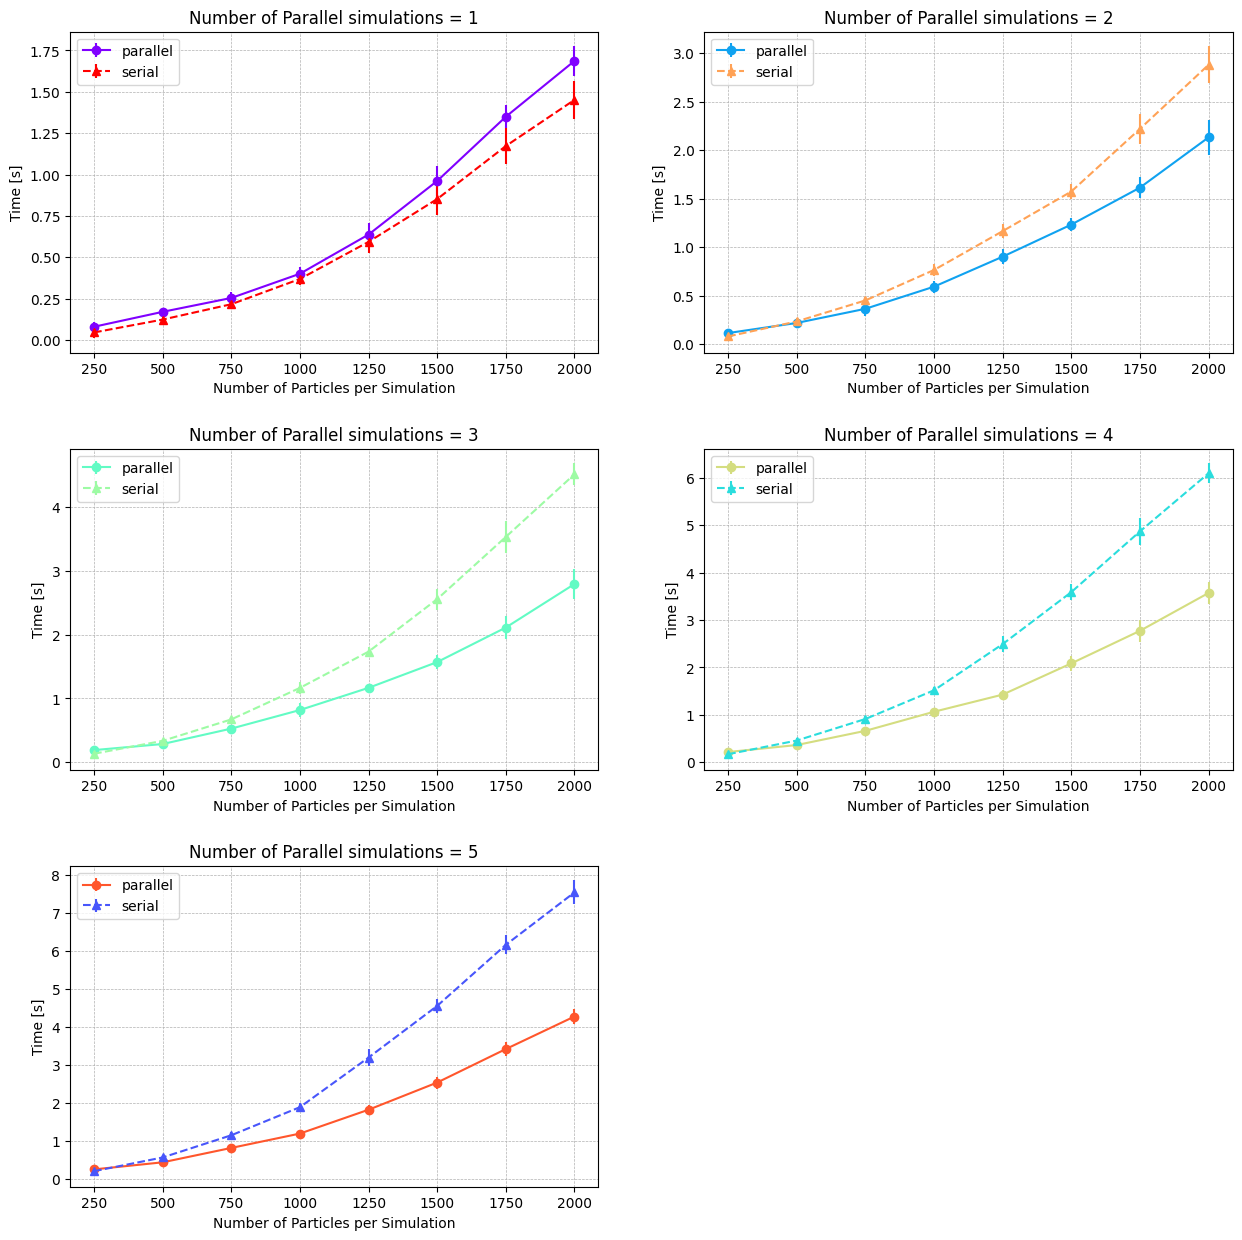

In [ ]:
# Making plots
df = pd.read_csv("./multiprocessing/multievo/parallel_vs_serial_ONETSTEP.csv")
std_group = df.groupby(['n_particles', 'n_simulations'])[['parallel_time', 'serial_time']].agg(['mean', 'std'])

fig,axs = plt.subplots(3,2,figsize=(15,15))

plt.subplots_adjust(hspace=0.3, wspace=0.2)
axs = axs.flatten() # for easy indexing

colors = [cm.rainbow(i) for i in np.linspace(0, 1, 10)]

i = 0 
for name, group in std_group[["parallel_time","serial_time"]].groupby("n_simulations"):
  
        
    ax = axs[i]
    
    # each group has n_particles fixed (that is its "name")
    n_particles = group["parallel_time"]["mean"].keys().get_level_values(0).values #[ 250  500  750 1000 1250 1500 1750 2000]
    # group.values are parallel times
    # group.values.shape (8,2)
    # Create new axes
    
    # group.values.shape = (8,4) mean,std,mean,std
    # Plot the scatter
    
    ax.errorbar(n_particles, group["parallel_time"].values[:,0], yerr=group["parallel_time"].values[:,1],marker="o", label="parallel",c= colors[2*i])
    ax.errorbar(n_particles, group["serial_time"].values[:,0], yerr=group["serial_time"].values[:,1], marker="^",label="serial",c= colors[-(2*i+1)],linestyle='--')
    
    # Set labels and title
    ax.set_xlabel('Number of Particles per Simulation')
    ax.set_ylabel('Time [s]')
    ax.set_title(f'Number of Parallel simulations = {name}')
    ax.grid(linestyle='--', linewidth=0.5)
    
    
    # Add legend
    ax.legend()

    i +=1 
    
fig.delaxes(axs[-1])

#plt.savefig("parallel_vs_serial.pdf")
# Show the plot
plt.show()
    


We see that the parallel simulations outperform the serial ones, only if more than $\sim 500$ particles per simulation are considered. Otherwise, there will only be an overhead introduced by the Pool.

We show the first plot (Number of simulations = 1) as benchmark, and indeed in that case serial is better because there are multiple workers that try to split the task between them, resulting in an inefficient waste of resources.

### Using Numba NJIT on parallel simulations

Now, let's put everything together and see if we can run multiple simulations in parallel, each of them computing the accelerations using the optimized numba njit functions. 